In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %% minimal bootstrap
import sys, os, subprocess, importlib.util
from pathlib import Path

def find_project_root(start: Path) -> Path:
    p = start.resolve()
    for _ in range(50):
        if any((p / m).exists() for m in ("pyproject.toml", ".git", "defaults.yaml")):
            return p
        if p == p.parent: break
        p = p.parent
    return start.resolve()

_here = Path(__file__).resolve() if "__file__" in globals() else Path.cwd().resolve()
ROOT = find_project_root(_here)
os.chdir(ROOT)
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

def ensure_editable_installed(pkg_name: str, pkg_dir: Path):
    spec = importlib.util.find_spec(pkg_name)
    need = (not spec) or (not getattr(spec, "origin", None)) or (Path(spec.origin).resolve().parents[0] != pkg_dir.resolve())
    if need:
        print(f"Installing {pkg_name} in editable mode from {pkg_dir} ...")
        subprocess.run([sys.executable, "-m", "pip", "install", "-e", str(pkg_dir)], check=True)
    else:
        print(f"{pkg_name} already installed from this repo.")

ensure_editable_installed("diffinst", ROOT / "diffinst")

# %% imports & paths
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from diffinst import Config
from diffinst.linear_ops import evp_solve_at_k
from diffinst.analysis_api import (
    load_manifest, load_config_from_run, list_checkpoints, load_metrics,
    load_linear_run, load_linear_Sigma_series, load_linear_amplitude,
    load_nonlinear_run, load_nonlinear_Sigma_series, load_nonlinear_amplitude,
    nearest_k_index, save_ic_npz, evp_gamma
)

EXP_DIFFSLOPE = ROOT / "experiments" / "diffinst.yaml"
DEFAULTS     = ROOT / "defaults.yaml"
RUNS         = ROOT / "runs"; RUNS.mkdir(exist_ok=True)

print("project root:", ROOT)



diffinst already installed from this repo.
project root: /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst


In [21]:
# Resolution Tests# %% global params & helpers for linear robustness tests

import subprocess
import sys


# Global knobs (you can tweak these)
K_MODE      = 100.0      # physical k for eigenmode ICs
#NX_IC       = 128        # grid size for ICs and TD runs
IC_AMP      = 1e-2       # small amplitude for linear regime
STOP_TIME   = 40.0       # total integration time (same for all runs, for now)
SAVE_STRIDE = 200        # how often to save checkpoints
PRINT_STRIDE = 400       # for nonlinear/dedalus logging


# Always the same yaml. Nx will be overwritten. still BRANCHES to define names though

BRANCHES = {
    "32": EXP_DIFFSLOPE,
    "64": EXP_DIFFSLOPE,
    "128": EXP_DIFFSLOPE,
    "254": EXP_DIFFSLOPE,
}

NX = {
    "32": 32,
    "64": 64,
    "128": 128,
    "254": 254,
}

DT_NONLIN = {
    "32":   1e-2,
    "64": 1e-2,
    "128": 1e-2,
    "254": 1e-3,
}

DT_DEDALUS = {
    "32":  1e-4,
    "64": 1e-4,
    "128": 1e-4,
    "254":1e-4,
}



# Base run directory for this notebook
RUN_BASE = ROOT / "runs" / "nonlinear_blowup"
RUN_BASE.mkdir(exist_ok=True)

IC_DIR = RUN_BASE / "ics"
IC_DIR.mkdir(exist_ok=True)

# Convenience: per-branch paths for IC and run directories
IC_PATHS = {
    name: IC_DIR / f"ic_{name}_k{int(K_MODE)}.npz"
    for name in BRANCHES.keys()
}

RUN_NL_NATIVE = {
    name: RUN_BASE / f"{name}_nl_native"
    for name in BRANCHES.keys()
}

RUN_DED_NL = {
    name: RUN_BASE / f"{name}_dedalus_nl"
    for name in BRANCHES.keys()
}


def run_cmd(cmd: list[str]):
    """Run a CLI command and raise if it fails; print stdout/stderr."""
    print("Running:", " ".join(str(c) for c in cmd))
    result = subprocess.run(cmd, text=True, capture_output=True)
    if result.stdout:
        print(result.stdout)
    if result.stderr:
        print(result.stderr)
    if result.returncode != 0:
        raise RuntimeError(f"Command failed with code {result.returncode}")

In [22]:
# %% build eigenmode ICs for all branches (gas-inclusive configs)

for name, cfg_path in BRANCHES.items():
    ic_path = IC_PATHS[name]
    Nx = NX[name]
    cmd = [
        sys.executable, "-m", "scripts.make_ic_eigen",
        "--config", str(cfg_path),
        "--out", str(ic_path),
        "--k", str(K_MODE),
        "--amp", str(IC_AMP),
        "--Nx", str(Nx),
        "--exact-fit-harm", "2",
    ]
    run_cmd(cmd)

print("Eigenmode ICs written to:")
for name, ic_path in IC_PATHS.items():
    print(f"  {name}: {ic_path}")

Running: /opt/anaconda3/envs/dedalus3/bin/python -m scripts.make_ic_eigen --config /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/experiments/diffinst.yaml --out /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/nonlinear_blowup/ics/ic_32_k100.npz --k 100.0 --amp 0.01 --Nx 32 --exact-fit-harm 2
[make_ic_eigen] IC written to /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/nonlinear_blowup/ics/ic_32_k100.npz (k=100.0, amp=0.01, Nx=32)

Running: /opt/anaconda3/envs/dedalus3/bin/python -m scripts.make_ic_eigen --config /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/experiments/diffinst.yaml --out /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/nonlinear_blowup/ics/ic_64_k100.npz --k 100.0 --amp 0.01 --Nx 64 --exact-fit-harm 2
[make_ic_eigen] IC written to /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/nonlinear_blowup/ics/ic_64_k100.npz (k=100.0, amp=

In [23]:
# %% run native nonlinear TD for all branches from eigenmode ICs

for name, cfg_path in BRANCHES.items():
    outdir = RUN_NL_NATIVE[name]
    outdir.mkdir(parents=True, exist_ok=True)
    Nx = NX[name]
    
    dt = DT_NONLIN[name]

    cmd = [
        sys.executable, "-m", "scripts.run_nonlinear",
        "--config", str(cfg_path),
        "--outdir", str(outdir),
        "--mode", "nonlinear",
        "--dt", str(dt),
        "--stop-time", str(STOP_TIME),
        "--save-stride", str(SAVE_STRIDE),
        "--init-from", str(IC_PATHS[name]),
        "--Nx", str(Nx),
        "--print-stride", "400",
        "--force",
    ]
    run_cmd(cmd)

print("Native nonlinear TD runs completed. Output dirs:")
for name, outdir in RUN_NL_NATIVE.items():
    print(f"  {name}: {outdir}")

Running: /opt/anaconda3/envs/dedalus3/bin/python -m scripts.run_nonlinear --config /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/experiments/diffinst.yaml --outdir /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/nonlinear_blowup/32_nl_native --mode nonlinear --dt 0.01 --stop-time 40.0 --save-stride 200 --init-from /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/nonlinear_blowup/ics/ic_32_k100.npz --Nx 32 --print-stride 400 --force
[INFO] Removing existing output directory: /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst/runs/nonlinear_blowup/32_nl_native
[nonlinear] done: {'t_final': 40.0, 'steps': 4000, 'Nx': 32, 'Lx': 0.12566370614359174}

2025-11-28 16:25:33,013 diffinst.solvers.native_nonlinear INFO :: Native nonlinear step=400  t=4.000000e+00  dt=1.000e-02
2025-11-28 16:25:33,385 diffinst.solvers.native_nonlinear INFO :: Native nonlinear step=800  t=8.000000e+00  dt=1.000e-02
2025-11-28 16:

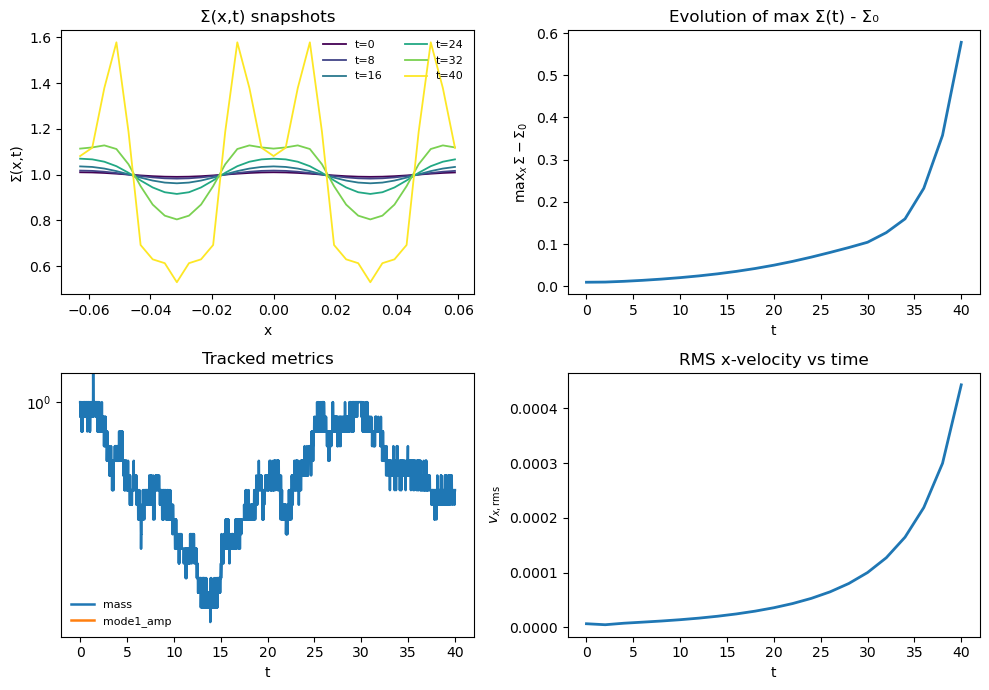

In [27]:
# %% diagnostics for the noise-seeded nonlinear run

RUN_NOISE =  RUN_NL_NATIVE['32']

# Load nonlinear density evolution
Nx, Lx, files, man = load_nonlinear_run(RUN_NOISE)
T, Sig = load_nonlinear_Sigma_series(files)   # T: (Nt,), Sig: (Nt, Nx)

# Physical grid
x = np.linspace(-0.5*Lx, 0.5*Lx, Nx, endpoint=False)

# Background Σ0 from config
cfg_noise = load_config_from_run(RUN_NOISE)
S0_noise = float(getattr(cfg_noise, "S0", getattr(cfg_noise, "sig_0", 1.0)))

# --- 1) Pick a few snapshots for Σ(x,t) ---
nsamp = 6
idxs = np.linspace(0, len(T) - 1, nsamp, dtype=int)

# --- 2) Time evolution of max Σ - Σ0 ---
Sig_max = Sig.max(axis=1)
Sig_max_minus = Sig_max - S0_noise

# --- 3) Solver metrics: mass, mode1_amp ---
tM, cols = load_metrics(RUN_NOISE)
mass = cols.get("mass", None)
mode1 = cols.get("mode1_amp", None)

# --- 4) vx_rms(t): need vx from checkpoints ---
vx_series = []
for fn in files:
    with np.load(fn) as Z:
        vx_series.append(np.asarray(Z["vx"]))
vx_series = np.array(vx_series)     # (Nt, Nx)
vx_rms = np.sqrt(np.mean(vx_series**2, axis=1))

# --- Plot: 2x2 panel with all diagnostics ---
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
(ax_snap, ax_max), (ax_metrics, ax_vx) = axes

# (a) Σ snapshots
cmap = plt.get_cmap("viridis")
for j, i in enumerate(idxs):
    frac = j / max(nsamp - 1, 1)
    ax_snap.plot(x, Sig[i], lw=1.3, color=cmap(frac), label=f"t={T[i]:.3g}")
ax_snap.set_xlabel("x")
ax_snap.set_ylabel("Σ(x,t)")
ax_snap.set_title("Σ(x,t) snapshots")
ax_snap.legend(ncol=2, fontsize=8, frameon=False)

# (b) max Σ - Σ0 vs time
ax_max.plot(T, Sig_max_minus, lw=2)
ax_max.set_xlabel("t")
ax_max.set_ylabel(r"max$_x\,\Sigma - \Sigma_0$")
ax_max.set_title("Evolution of max Σ(t) - Σ₀")

# (c) metrics: mass and mode1_amp
if mass is not None:
    n = min(len(tM), len(mass))
    ax_metrics.plot(tM[:n], mass[:n], lw=1.8, label="mass")
if mode1 is not None:
    n = min(len(tM), len(mode1))
    ax_metrics.plot(tM[:n], mode1[:n], lw=1.8, label="mode1_amp")
ax_metrics.set_xlabel("t")
ax_metrics.set_title("Tracked metrics")
ax_metrics.legend(frameon=False, fontsize=8)
ax_metrics.set(yscale = "log")

# (d) vx_rms(t)
ax_vx.plot(T, vx_rms, lw=2)
ax_vx.set_xlabel("t")
ax_vx.set_ylabel(r"$v_{x,\mathrm{rms}}$")
ax_vx.set_title("RMS x-velocity vs time")

plt.tight_layout()
plt.show()